# XLM-RoBERTa
*Time for run all (GPU): ~4 hours*

## 1. General Settings and Import Libraries

In [ ]:
! pip install torchtext==0.17.2

In [ ]:
import pprint
import numpy as np
import pandas as pd

from sklearn import preprocessing, metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import torch
from torch import Tensor
from torch.utils.data import DataLoader
from torch.optim import AdamW
import torchtext
import torchtext.transforms as T
import torchtext.functional as F
from torchtext.models import RobertaClassificationHead, XLMR_BASE_ENCODER

import pickle

## 2. Data Preparation

In [ ]:
train_df = pd.read_csv('data/stock_train.csv')
test_df = pd.read_csv('data/stock_test.csv')

In [ ]:
train_df

,text,label,label_id
0,"Tại thị trường trong nước, khảo sát lúc 9 giờ ...",positive,0
1,tăng 50.000 đồng/lượng ở cả hai chiều mua và b...,positive,0
2,Tại 2 thị trường lớn khác là Hà Nội và Đà Nẵng...,positive,0
3,Vàng lại bật tăng vượt ngưỡng 2.000 USD/ounce,positive,0
4,tăng 24 USD/ounce so với cùng giờ sáng qua,positive,0
...,...,...,...
1511,Danh mục đầu tư 60/40 là mô hình phân chia tài...,neutral,2
1512,"Theo tính toán của Vanguard, lợi nhuận hàng nă...",neutral,2
1513,Nhóm chuyên gia JP Morgan xem xét 200 loại tài...,neutral,2
1514,Kết luận đưa ra là các nguyên tắc cốt lõi của ...,neutral,2


In [ ]:
test_df

,text,label,label_id
0,Tại 2 thị trường lớn khác là Hà Nội và Đà Nẵng...,positive,0
1,"Như vậy, trong 2 ngày qua, giá vàng nhẫn đã tă...",positive,0
2,"Giá vàng thế giới bật tăng trở lại, khi lực cầ...",positive,0
3,"Tại thị trường thế giới, thời điểm lúc 9 giờ 3...",positive,0
4,"Tuy nhiên, sau đó lực cầu bắt đáy mạnh đã giúp...",positive,0
...,...,...,...
1135,"Ngoài 47 triệu cổ phiếu khớp lệnh, HAG còn ghi...",neutral,2
1136,báo cáo giải trình của SHS cho biết,neutral,2
1137,"Cuối quý I, SHS nắm giữ 2.240 tỷ đồng cổ phiếu...",neutral,2
1138,SHS còn nắm giữ hơn 420 tỷ đồng TCB với giá tr...,neutral,2


In [ ]:
! pip install pyvi

In [ ]:
from pyvi import ViTokenizer
def clean_text(text):
    text = text.lower()
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^,_' + "'`"
    for p in punctuations:
        text = text.replace(p,'')
    text = ViTokenizer.tokenize(text)
    return text

In [ ]:
train_df.text[0:5].apply(clean_text)

,text
0,tại thị_trường trong nước khảo_sát lúc 9 giờ s...
1,tăng 50000 đồnglượng ở cả hai chiều mua và bán...
2,tại 2 thị_trường lớn khác là hà_nội và đà_nẵng...
3,vàng lại bật tăng vượt ngưỡng 2000 usdounce
4,tăng 24 usdounce so với cùng giờ sáng qua


In [ ]:
train_df['text'] = train_df['text'].apply(clean_text)
test_df['text'] = test_df['text'].apply(clean_text)

In [ ]:
label_encoder = preprocessing.LabelEncoder()
train_df['label'] = label_encoder.fit_transform(train_df['label'])

In [ ]:
test_df['label'] = label_encoder.transform(test_df['label'])

In [ ]:
class PadTransform(torch.nn.Module):
    """Pad tensor to a fixed length with given padding value.
    :param max_length: Maximum length to pad to
    :type max_length: int
    :param pad_value: Value to pad the tensor with
    :type pad_value: bool
    """

    def __init__(self, max_length: int, pad_value: int) -> None:
        super().__init__()
        self.max_length = max_length
        self.pad_value = float(pad_value)

    def forward(self, x: Tensor) -> Tensor:
        """
        :param x: The tensor to pad
        :type x: Tensor
        :return: Tensor padded up to max_length with pad_value
        :rtype: Tensor
        """
        max_encoded_length = x.size(-1)
        if max_encoded_length < self.max_length:
            pad_amount = self.max_length - max_encoded_length
            x = torch.nn.functional.pad(x, (0, pad_amount), value=self.pad_value)
        return x

In [ ]:
padding_idx = 1
bos_idx = 0
eos_idx = 2
max_seq_len = 256

In [ ]:
text_transform = torchtext.models.XLMR_LARGE_ENCODER.transform()

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return (
            torch.tensor(text_transform(self.df.iloc[idx, 0])),
            torch.tensor(self.df.iloc[idx, 1])
        )

In [ ]:
train_dataset = CustomDataset(train_df)
test_dataset = CustomDataset(test_df)

In [ ]:
SMALL_BATCH_SIZE = 16
K = 2
LARGE_BATCH_SIZE = K * SMALL_BATCH_SIZE

In [ ]:
def batch_collate_fn(batch):
    inp_list = list()
    tar_list = list()

    for sample in batch:
        inp_list.append(sample[0].tolist())
        tar_list.append(sample[1])

    padded_tensor = F.to_tensor(inp_list, padding_value=padding_idx)
    target_tensor = torch.stack(tar_list).type(torch.LongTensor)

    return padded_tensor, target_tensor

In [ ]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=SMALL_BATCH_SIZE,
    shuffle=True,
    collate_fn=batch_collate_fn
)

In [ ]:
test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=SMALL_BATCH_SIZE,
    shuffle=False,
    collate_fn=batch_collate_fn
)

In [ ]:
num_classes = 3
input_dim = 768

In [ ]:
classifier_head = RobertaClassificationHead(num_classes=num_classes, input_dim=input_dim)
model = XLMR_BASE_ENCODER.get_model(head=classifier_head)

In [ ]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
model.to(DEVICE)
pass

In [ ]:
learning_rate = 1.2e-5
optim = AdamW(model.parameters(), lr=learning_rate)
criteria = torch.nn.CrossEntropyLoss()

## 3. Model Training and Evaluation

In [ ]:
def train_step(input, target, small_batch_no):
    output = model(input)
    loss = criteria(output, target)
    loss.backward()

    if (small_batch_no + 1) % K == 0 or (small_batch_no + 1) == len(train_dataloader):
        optim.step()
        optim.zero_grad()

    return loss.item() / input.size(dim=0)

def evaluate():
    model.eval()
    total_loss = 0
    counter = 0

    with torch.no_grad():
        for i, batch in enumerate(test_dataloader):
            input = batch[0].clone().detach().to(DEVICE)
            output = model(input)
            target = batch[1].clone().detach().to(DEVICE)

            if i == 0:
                class_output = torch.argmax(output, dim=1)
                class_target = target
            else:
                class_output = torch.cat([class_output, torch.argmax(output, dim=1)])
                class_target = torch.cat([class_target, target])

            loss = criteria(output, target).item()
            total_loss += loss
            counter += input.size(dim=0)


        confusion_matrix = metrics.confusion_matrix(
            class_target.cpu().numpy().flatten(),
            class_output.cpu().numpy().flatten(),
            labels=[0, 1, 2]
        )
        classification_report = metrics.classification_report(
            class_target.cpu().numpy().flatten(),
            class_output.cpu().numpy().flatten(),
            labels=[0, 1, 2],
            output_dict=True
        )

    return (
        total_loss,
        counter,
        confusion_matrix,
        classification_report
    )

In [ ]:
num_epochs = 20

In [ ]:
def save_log(epoch, **kwargs):
    with open(f'log_{epoch}.pkl', 'wb') as f:
        pickle.dump(kwargs, f)

def save_model(message):
    torch.save(model.state_dict(), f'model_{message}.pth')
    print('Model saved successfully')

In [ ]:
max_accuracy = float('-inf')
max_macro_f1 = float('-inf')
max_weighted_f1 = float('-inf')

In [ ]:
for epoch in range(num_epochs):
    model.train()
    avg_training_losses = list()

    for small_batch_no, small_batch in enumerate(train_dataloader):
        input = small_batch[0].clone().detach().to(DEVICE)
        target = small_batch[1].clone().detach().to(DEVICE)
        avg_training_losses.append(
            train_step(input, target, small_batch_no)
        )
        torch.cuda.empty_cache()

    total_loss, counter, confusion_matrix, classification_report = evaluate()
    print(f'EPOCH {epoch}')
    print(f'Mean of avg_training_losses={np.mean(avg_training_losses)}')
    print(f'total_loss={total_loss}')
    print(f'counter={counter}')
    print(f'loss=total_loss/counter={total_loss/counter}')
    print(f'confusion_matrix=\n{confusion_matrix}')
    print('classification_report=')
    pprint.pprint(classification_report)

    save_log(
        epoch,
        avg_training_losses=avg_training_losses,
        total_loss=total_loss,
        counter=counter,
        loss=total_loss/counter,
        confusion_matrix=confusion_matrix,
        classification_report=classification_report
    )

    if classification_report['accuracy'] > max_accuracy:
        print(f'New max_accuracy')
        max_accuracy = classification_report['accuracy']
        max_accuracy_index = epoch
        save_model('max_accuracy')

    elif classification_report['macro avg']['f1-score'] > max_macro_f1:
        print(f'New max_macro_f1')
        max_macro_f1 = classification_report['macro avg']['f1-score']
        max_macro_f1_index = epoch
        save_model('max_macro_f1')

    elif classification_report['weighted avg']['f1-score'] > max_weighted_f1:
        print(f'New max_weighted_f1')
        max_weighted_f1 = classification_report['weighted avg']['f1-score']
        max_weighted_f1_index = epoch
        save_model('max_weighted_f1')

    elif epoch == num_epochs - 1:
        save_model(f'{epoch}_last')

    elif epoch % 40 == 0:
        save_model(f'{epoch}_checkpoint')

    else:
        continue

save_log(
    'post_train_info',
    max_accuracy=max_accuracy,
    max_accuracy_index=max_accuracy_index,
    max_macro_f1=max_macro_f1,
    max_macro_f1_index=max_macro_f1_index,
    max_weighted_f1=max_weighted_f1,
    max_weighted_f1_index=max_weighted_f1_index
)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


EPOCH 0
Mean of avg_training_losses=0.06895518446700614
total_loss=79.03740775585175
counter=1140
loss=total_loss/counter=0.06933105943495767
confusion_matrix=
[[  0   0 341]
 [  0   0 426]
 [  0   0 373]]
classification_report=
{'0': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 341.0},
 '1': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 426.0},
 '2': {'f1-score': 0.4930601454064772,
       'precision': 0.32719298245614037,
       'recall': 1.0,
       'support': 373.0},
 'accuracy': 0.32719298245614037,
 'macro avg': {'f1-score': 0.16435338180215905,
               'precision': 0.10906432748538013,
               'recall': 0.3333333333333333,
               'support': 1140.0},
 'weighted avg': {'f1-score': 0.16132581950580352,
                  'precision': 0.10705524776854417,
                  'recall': 0.32719298245614037,
                  'support': 1140.0}}
New max_accuracy
Model saved successfully


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


EPOCH 1
Mean of avg_training_losses=0.068805010459925
total_loss=78.74313312768936
counter=1140
loss=total_loss/counter=0.06907292379621874
confusion_matrix=
[[  0   0 341]
 [  0   0 426]
 [  0   0 373]]
classification_report=
{'0': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 341.0},
 '1': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 426.0},
 '2': {'f1-score': 0.4930601454064772,
       'precision': 0.32719298245614037,
       'recall': 1.0,
       'support': 373.0},
 'accuracy': 0.32719298245614037,
 'macro avg': {'f1-score': 0.16435338180215905,
               'precision': 0.10906432748538013,
               'recall': 0.3333333333333333,
               'support': 1140.0},
 'weighted avg': {'f1-score': 0.16132581950580352,
                  'precision': 0.10705524776854417,
                  'recall': 0.32719298245614037,
                  'support': 1140.0}}
New max_macro_f1
Model saved successfully
EPOCH 2
Mean of avg_training_losses=0.066765536080

*Maximum recorded accuracy = 82.04%*

### 4. Analyzing model

In [ ]:
import pickle as pkl
with open('log_0.pkl', 'rb') as f:
    pprint.pprint(pkl.load(f))

{'avg_training_losses': [0.06732410192489624,
                         0.06833431124687195,
                         0.06907189637422562,
                         0.06960426270961761,
                         0.06947363913059235,
                         0.06914066523313522,
                         0.06913081556558609,
                         0.06740792095661163,
                         0.06999890506267548,
                         0.06813013553619385,
                         0.06896544992923737,
                         0.068419449031353,
                         0.06936649233102798,
                         0.06815041601657867,
                         0.06875760108232498,
                         0.06975143402814865,
                         0.06703774631023407,
                         0.0692865177989006,
                         0.06713219732046127,
                         0.06691797077655792,
                         0.06693141162395477,
                         0.0705379694

In [ ]:
means_avg_training_losses = list()
accuracies = list()
macro_f1_scores = list()
weighted_f1_scores = list()

for i in range(20):
    with open(f'log_{i}.pkl', 'rb') as f:
        log_dict = pkl.load(f)
        means_avg_training_losses.append(np.mean(log_dict['avg_training_losses']))
        accuracies.append(log_dict['classification_report']['accuracy'])
        macro_f1_scores.append(log_dict['classification_report']['macro avg']['f1-score'])
        weighted_f1_scores.append(log_dict['classification_report']['weighted avg']['f1-score'])

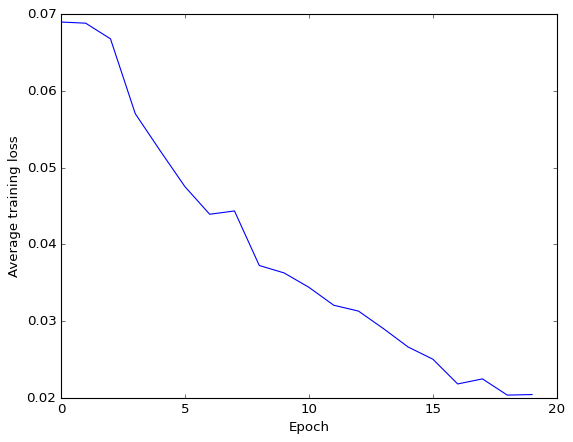

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

plt.figure(figsize=(8, 6), facecolor='white')
plt.plot(means_avg_training_losses)
plt.xlabel('Epoch')
plt.ylabel('Average training loss')
plt.savefig('avg training loss.png', dpi=200)

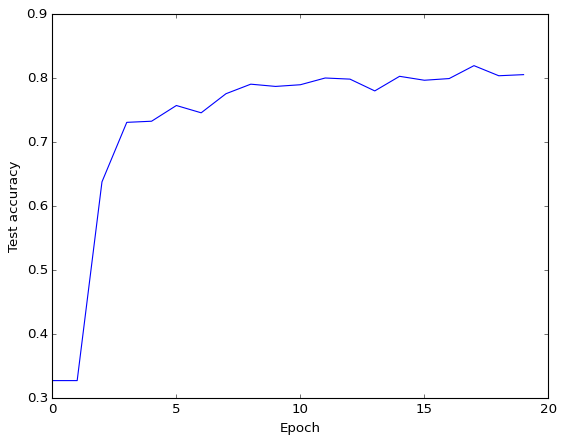

In [ ]:
plt.figure(figsize=(8, 6), facecolor='white')
plt.plot(accuracies)
plt.xlabel('Epoch')
plt.ylabel('Test accuracy')
plt.savefig('test accuracy.png', dpi=200)

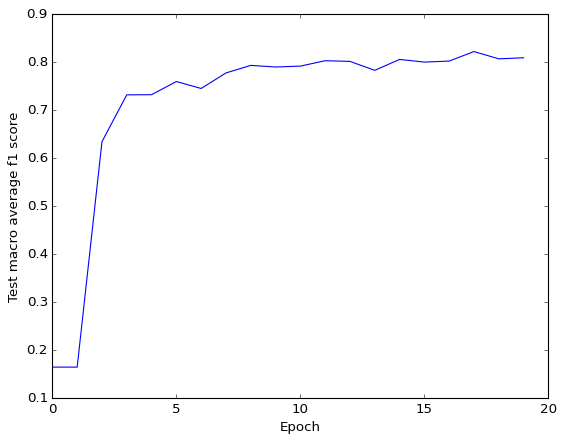

In [ ]:
plt.figure(figsize=(8, 6), facecolor='white')
plt.plot(macro_f1_scores)
plt.xlabel('Epoch')
plt.ylabel('Test macro average f1 score')
plt.savefig('test macro avg f1.png', dpi=200)

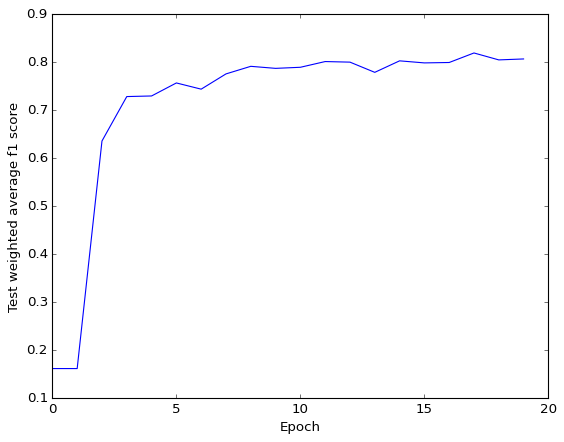

In [ ]:
plt.figure(figsize=(8, 6), facecolor='white')
plt.plot(weighted_f1_scores)
plt.xlabel('Epoch')
plt.ylabel('Test weighted average f1 score')
plt.savefig('test weighted avg f1.png', dpi=200)

In [ ]:
with open('log_post_train_info.pkl', 'rb') as f:
    post_train_info = pkl.load(f)
    pprint.pprint(post_train_info)

{'max_accuracy': 0.8192982456140351,
 'max_accuracy_index': 17,
 'max_macro_f1': 0.8088110151986224,
 'max_macro_f1_index': 19,
 'max_weighted_f1': 0.7981283356063976,
 'max_weighted_f1_index': 15}


### 5. Demonstration

In [ ]:
def prepare_model():
    num_classes = 3
    input_dim = 768

    classifier_head = RobertaClassificationHead(num_classes=num_classes, input_dim=input_dim)
    model = XLMR_BASE_ENCODER.get_model(head=classifier_head)

    DEMO_MODEL_PATH = 'model_max_macro_f1.pth'
    model.load_state_dict(torch.load(DEMO_MODEL_PATH))
    model.to(DEVICE)

    print(f'Loaded model to [{DEVICE}] in [{DEMO_MODEL_PATH}]')
    return model

In [ ]:
def prepare_text_transform():
    text_transform = torchtext.models.XLMR_LARGE_ENCODER.transform()
    return text_transform

In [ ]:
def predict(sentence, model, text_transform):
    transformed_text = text_transform(sentence)
    out = model(torch.tensor([transformed_text]).to(DEVICE))
    return torch.argmax(out).item()

In [ ]:
model = prepare_model()
text_transform = prepare_text_transform()

Loaded model to [cuda] in [model_max_macro_f1.pth]


In [ ]:
test_df

,text,label,label_id
0,tại 2 thị_trường lớn khác là hà_nội và đà_nẵng...,2,0
1,như_vậy trong 2 ngày qua giá vàng nhẫn đã tăng...,2,0
2,giá vàng thế_giới bật tăng trở_lại khi lực cầu...,2,0
3,tại thị_trường thế_giới thời_điểm lúc 9 giờ 30...,2,0
4,tuy_nhiên sau đó lực cầu bắt đáy mạnh đã giúp ...,2,0
...,...,...,...
1135,ngoài 47 triệu cổ_phiếu khớp lệnh hag còn ghi_...,1,2
1136,báo_cáo giải_trình của shs cho biết,1,2
1137,cuối quý i shs nắm giữ 2240 tỷ đồng cổ_phiếu t...,1,2
1138,shs còn nắm giữ hơn 420 tỷ đồng tcb với giá_tr...,1,2


In [ ]:
test_df['prediction'] = test_df['text'].apply(lambda x: predict(x, model, text_transform))

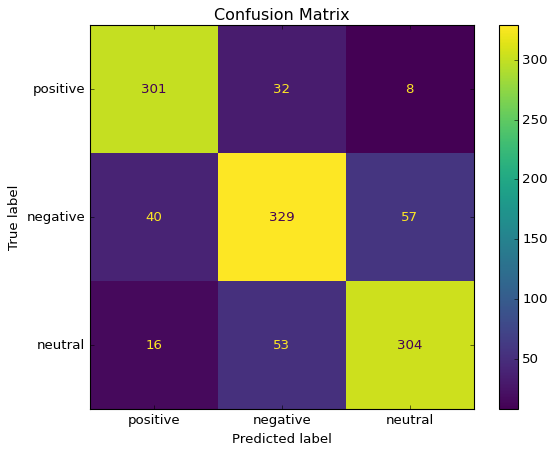

In [ ]:
target_names = ['positive', 'negative', 'neutral']
with open(f'log_17.pkl', 'rb') as f:
        log_dict = pkl.load(f)
        cm = log_dict['confusion_matrix']
_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
fig, ax = plt.subplots(figsize=(8, 6), facecolor='white')
_display.plot(ax=ax)
plt.title('Confusion Matrix')
plt.show()